Related tweet:
    https://twitter.com/sassorgsa/status/1138767881192333313

<div dir="rtl" lang="ar">

لنفرض ان لدينا بيانات عن جميع سكان مدينة الرياض كـ **العمر**، **الوزن**، **الطول**، **اللون** (دعنا نسميها بالـ **خصائص** أو الأبعاد). ونرغب في تقسيم هذه البيانات إلى عدة مجموعات بحيث أن كل مجموعة ستحتوي على أشخاص متشابهين (أي يملكون خصائص مشابهة). 

**كيف يمكننا القيام بذلك**؟

**الجواب**: يمكننا استخدام **خوارزمية التجميع**


# شرح خوارزمية التجميع (أو التصنيف) k-means


تستخدم هذه الخوارزمية كثيراً في مجال **تعلم الآلة** و **علم البيانات** لتجميع "تقسيم" نقاط البيانات المتشابهه (المتقاربة) مع بعضها البعض في عدد معين من المجموعات.


في هذا الشرح، ولغرض تبسيط المفهوم:


- سنستخدم عدد صغير من البيانات لشرح كيف تعلم الخوارزمية بالتفصيل. 
- سنفترض بيانات وهمية لـ _الوزن_ و _الطول_ لعشرة اشخاص فقط. لاحظ **خاصيتين** فقط بمعنى كل نقطة في مدخلات البيانات ستحتوي على **بعدين**. عموماً، يمكن تطبيق نفس مفهوم الخوارزمية لأي عدد من الأبعاد.
- سنقوم بكتابة الخوارزمية من الصفر بدون إستخدام أي مكتبات برمجية جاهزة.


>  ملاحظة: يمكن للبيانات أن تكون عن أي شي معين و يمكن ان تحتوي على اكثر من بعد او خاصية، مثلاً: بيانات مرضى، أو قياسات درجات حرارة، أو أسعار اسهم، وغيرها

</div>


<div dir="rtl" lang="ar">
<meta charset="utf-8">

دعنا أولاً نبداً بـ بيانات الطول و الوزن للعشرة أشخاص، كالتالي: 

</div>

In [1]:
weights = [74, 77, 81, 76, 80, 91, 88, 93, 88, 92]           # الوزن بالكيلوغرام
heights = [179, 182, 181, 175, 174, 182, 178, 178, 174, 173] # الطول بالسنتيمتر

<div dir="rtl" lang="ar">
<meta charset="utf-8">

لنصور البيانات بشكل افضل، سنتعرضها في الرسم البياني التالي:
  
</div>

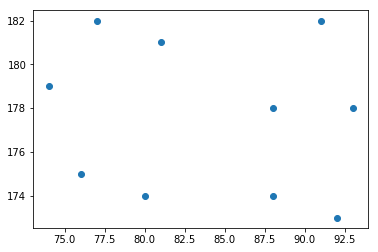

In [3]:
# أمر خاص بالنوتبوك لعرض الرسوم البيانية هنا مباشرة
%matplotlib inline
import matplotlib.pyplot as plt        # نستدعي مكتبة الرسوم البيانية
plt.scatter(weights, heights);         # نعطيها بيانات الطول و الوزن

<div dir="rtl" lang="ar">
<meta charset="utf-8">
من اجل تسهيل كتابة الكود، سنضع البيانات في متغير واحد. نسميه الأمثلة. كما يلي:

</div>

In [4]:
samples = [list(point) for point in zip(weights, heights)]
samples

[[74, 179],
 [77, 182],
 [81, 181],
 [76, 175],
 [80, 174],
 [91, 182],
 [88, 178],
 [93, 178],
 [88, 174],
 [92, 173]]

<div dir="rtl" lang="ar">
فيما يلي، راح نكتب دالة لحساب المسافة بين نقطتين (االمسافة العادية، نفس المسافة الناتجة إذا استخدمنا المسطرة). هذي المسافة تسمى المسافة الإقليدية، ويتم حسابها بين نقطين $U=(u_1, u_2, ...,u_n)$ و $V=(v1, v2, ..., v_n)$ بحيث ان $n$ هو عدد الأبعاد في كل نقطة كما يلي: 
</div>

$$
\sqrt{\left(u_{1}-v_{1}\right)^{2}+\left(u_{2}-v_{2}\right)^{2}+\cdots+\left(u_{n}-v_{n}\right)^{2}}=\sqrt{\sum_{i=1}^{n}\left(u_{i}-v_{i}\right)^{2}}
$$

In [12]:
def distance(u, v):
    """
    حساب المسافة الإقليدية بين نقطتين
    المسافة = square_root( (u0 - v0)^2 + (u1 - v1)^2) )
    
    u: [int, int], النقطة الأولى
    v: [int, int], النقطة الثانية
    """
    sum_ = sum( (u[i] - v[i])**2 for i in range(len(u)) ) # ناتج الجمع اللي تحت الجذر
    return sum_**(1/2)                                    # نأخذ الجذر للمجموع

In [13]:
# اختبار الدالة
u, v = samples[0], samples[1]
print(u, v)
print(distance(u, v))

[74, 179] [77, 182]
4.242640687119285


<div dir="rtl" lang="ar">
الآن، سنكتب دالة تأخذ ثلاث نقاط (االنقطة الهدف و نقطتين أخرى) وترجع النقطة (من النقطتين) الأقرب إلى النقطة الهدف. كما يلي:

</div>

In [14]:
def get_closer(c1, c2, p):
    """
    حساب أي النقطتين اقرب إلى النقطة الهدف
    
    
    c1: [int, int], النقطة الأولى
    c2: [int, int], النقطة الثانية
    p:  [int, int], النقطة الهدف
    """
    dc1 = distance(c1, p)
    dc2 = distance(c2, p)
    return c1 if dc1 < dc2 else c2

In [29]:
target = samples[2]
points = [u, v, target]
closer = get_closer(*points)
print(points)
closer

[[74, 179], [77, 182], [81, 181]]


[77, 182]

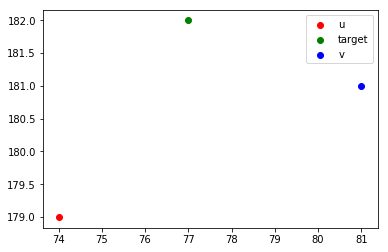

In [40]:
for p, c, l in zip(points, ['r', 'g', 'b'], ['u', 'target', 'v']):
    plt.scatter(*p, color=c, label=l)
plt.legend();

In [16]:
# Return midpoint between p1 and p2
def get_midpoint(p1, p2):
    mid = (p1[0] + p2[0])/2, (p1[1] + p2[1])/2
    return np.array(mid)


# k-means algorithm 'recursively'
def cluster(seed1, seed2):

    c1 = []
    c2 = []
    # cluster each data point to its closest seed
    for p in all_data:
        nearest = get_closer(seed1, seed2, p)
        if np.all(seed1 == nearest):
            c1.append([p[0],p[1]])
        else:
            c2.append([p[0],p[1]])
    c1, c2 = np.array(c1), np.array(c2)
    
    # get the new means
    m11 = float("{0:.2f}".format(c1[:,0].mean()))
    m12 = float("{0:.2f}".format(c1[:,1].mean()))
    m21 = float("{0:.2f}".format(c2[:,0].mean()))
    m22 = float("{0:.2f}".format(c2[:,1].mean()))
    
    # update seeds as the new means
    c1_seed = np.array([m11, m12])
    c2_seed = np.array([m21, m22])

    # return when converge
    if np.all(seed1 == c1_seed) and np.all(seed2 == c2_seed):
        m = np.array([seed1, seed2])
        mid = get_midpoint(m[0], m[1])
        return c1, c2, m, mid

    # if not converge, recurse with new means as the seeds
    print("ITERATION:\n\t", "starting seed: {}{} means: {} {}".format(seed1, seed2, c1_seed, c2_seed))
    return cluster(c1_seed, c2_seed)




# plot and print results
def report_result(seed1, seed2, c1, c2 ,m , mid):
    s1 = np.array([seed1, seed2])
    print("FINAL:\npair: {}{}\nmeans: {}{}\nmid: {}\ncluster1:{}\ncluster2:{}".format(seed1,seed2,m[0],m[1], mid,[c for c in c1],[c for c in c2]))
    # plot
    plt.scatter(c1[:,0], c1[:,1], c='r', label="cluster 1")
    plt.scatter(c2[:,0], c2[:,1], c='b', label="cluster 2")
    plt.plot(s1[:,0], s1[:,1], '--g', label="starting pair")
    plt.scatter(m.T[0], m.T[1], marker="d", c='y', label="means: 1 and 2")
    plt.plot(m.T[0], m.T[1], c='g') # line between means
    plt.scatter(mid[0], mid[1], marker='x', label='midpoint')
    plt.grid();plt.legend(bbox_to_anchor = (2, 1));plt.show()